In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Reading in the dataset
connect_df = pd.read_csv('connect-4.data',names=['a1','a2','a3','a4','a5','a6','b1','b2','b3','b4','b5','b6',
                                                 'c1','c2','c3','c4','c5','c6','d1','d2','d3','d4','d5','d6',
                                                 'e1','e2','e3','e4','e5','e6','f1','f2','f3','f4','f5','f6',
                                                 'g1','g2','g3','g4','g5','g6','win'])
connect_df

,a1,a2,a3,a4,a5,a6,b1,b2,b3,b4,...,f4,f5,f6,g1,g2,g3,g4,g5,g6,win
0,b,b,b,b,b,b,b,b,b,b,...,b,b,b,b,b,b,b,b,b,win
1,b,b,b,b,b,b,b,b,b,b,...,b,b,b,b,b,b,b,b,b,win
2,b,b,b,b,b,b,o,b,b,b,...,b,b,b,b,b,b,b,b,b,win
3,b,b,b,b,b,b,b,b,b,b,...,b,b,b,b,b,b,b,b,b,win
4,o,b,b,b,b,b,b,b,b,b,...,b,b,b,b,b,b,b,b,b,win
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67552,x,x,b,b,b,b,o,x,o,b,...,b,b,b,o,o,x,b,b,b,loss
67553,x,x,b,b,b,b,o,b,b,b,...,b,b,b,o,x,o,o,x,b,draw
67554,x,x,b,b,b,b,o,o,b,b,...,b,b,b,o,x,x,o,b,b,loss
67555,x,o,b,b,b,b,o,b,b,b,...,b,b,b,o,x,o,x,x,b,draw


In [3]:
# Checking if there are null values in the dataset
connect_df.isnull().values.any()

False

In [4]:
#One Hot Encoding
connect_cleaned_df = pd.get_dummies(connect_df)
connect_cleaned_df['win'] = connect_cleaned_df.loc[:,'win_win']
connect_cleaned_df = connect_cleaned_df.drop(['win_draw','win_loss','win_win'],axis=1)
connect_cleaned_df['win'].value_counts()
connect_cleaned_df

,a1_b,a1_o,a1_x,a2_b,a2_o,a2_x,a3_b,a3_o,a3_x,a4_b,...,g4_b,g4_o,g4_x,g5_b,g5_o,g5_x,g6_b,g6_o,g6_x,win
0,1,0,0,1,0,0,1,0,0,1,...,1,0,0,1,0,0,1,0,0,1
1,1,0,0,1,0,0,1,0,0,1,...,1,0,0,1,0,0,1,0,0,1
2,1,0,0,1,0,0,1,0,0,1,...,1,0,0,1,0,0,1,0,0,1
3,1,0,0,1,0,0,1,0,0,1,...,1,0,0,1,0,0,1,0,0,1
4,0,1,0,1,0,0,1,0,0,1,...,1,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67552,0,0,1,0,0,1,1,0,0,1,...,1,0,0,1,0,0,1,0,0,0
67553,0,0,1,0,0,1,1,0,0,1,...,0,1,0,0,0,1,1,0,0,0
67554,0,0,1,0,0,1,1,0,0,1,...,0,1,0,1,0,0,1,0,0,0
67555,0,0,1,0,1,0,1,0,0,1,...,0,0,1,0,0,1,1,0,0,0


In [5]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

lg_accuracy_train = []
lg_roc_auc_train = []
lg_f1_train = []
lg_precision_train = []

lg_accuracy_test = []
lg_roc_auc_test = []
lg_f1_test = []
lg_precision_test = []

lg_Y_pred_list = []
lg_Y_test_list = []

C_val = [1e-8,1e-7,1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]

# 10 Trials
for i in range(10):
    #Random 5000 per trial
    connect_shuffle_df = connect_cleaned_df.sample(frac = 1)
    
    #Train and Test set
    X_train,X_test = connect_shuffle_df.iloc[:5000,0:-1],connect_shuffle_df.iloc[5000:,0:-1]
    Y_train,Y_test = connect_shuffle_df.iloc[:5000,-1],connect_shuffle_df.iloc[5000:,-1]

    # Create a pipeline - RF is a stand in, we will populate the classifier part below
    pipe = Pipeline([('classifier', LogisticRegression())])

    # Create search space of candidate learning algorithms and their hyperparameters
    # note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
    search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': C_val},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','sag','newton-cg'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': C_val}
                ]

    # Create grid search 
    clf_lg = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                   scoring=['accuracy', 'roc_auc', 'f1','precision'], refit=False,
                   verbose=0,n_jobs=-1)

    # Fit grid search
    best_model = clf_lg.fit(X_train, Y_train)
    
    # Creating a Dataframe to contain the accuracy result per trial
    if i == 0:
        heat_results = pd.DataFrame( best_model.cv_results_['params'])
    # next grab the score resulting from those parameters, add it to the data
    # score is accuracy; to display it as misclassification error we use 1 - x   
    heat_results['score_acc_'+ str(i+1)] = 1 - best_model.cv_results_['mean_test_accuracy'] 
    # get rid of classifier__XX in columns
    cols = heat_results.columns.to_series().str.split('__').apply(lambda x: x[-1])
    heat_results.columns = cols
    
    # Getting the best classifiers
    best_acc_param = (best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_accuracy'])])
    best_roc_auc_param = (best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_roc_auc'])])
    best_f1_param =(best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_f1'])])
    best_precision_param = (best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_precision'])])

    # Creating Logistical Regression based on best parameters
    acc_lg_1 = pipe.set_params(**best_acc_param)
    acc_lg = acc_lg_1.fit(X_train,Y_train) #Retrains on entire 5k samples
    print('LG_ACC Trial #',i,':',acc_lg.score(X_train,Y_train)) # Trainng Raw Scores On 5k Refitting
    lg_accuracy_train.append(acc_lg.score(X_train,Y_train))
    print('LG_ACC Test #',i,':',acc_lg.score(X_test,Y_test)) # Testing Scores
    lg_accuracy_test.append(acc_lg.score(X_test,Y_test))
    
    roc_auc_lg_1 = pipe.set_params(**best_roc_auc_param)
    roc_auc_lg = roc_auc_lg_1.fit(X_train,Y_train) #Retrains on entire 5k samples
    print('LG_ROC_AUC_OVR Trial #',i,':', roc_auc_score(Y_train,roc_auc_lg.predict_proba(X_train)[:,1])) # Trainng Raw Scores On 5k Refitting
    lg_roc_auc_train.append(roc_auc_score(Y_train,roc_auc_lg.predict_proba(X_train)[:,1]))
    print('LG_ROC_AUC Test #',i,':',roc_auc_score(Y_test,roc_auc_lg.predict_proba(X_test)[:,1])) # Testing Scores
    lg_roc_auc_test.append(roc_auc_score(Y_test,roc_auc_lg.predict_proba(X_test)[:,1]))
    
    #Roc Auc Curve https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
    #Appending each trial together to see the overall ROC curve
    lg_Y_pred_list.append(roc_auc_lg.predict_proba(X_test)[:,1])
    lg_Y_test_list.append(Y_test)
                             
                             
    f1_lg_1 = pipe.set_params(**best_f1_param)
    f1_lg = f1_lg_1.fit(X_train,Y_train) #Retrains on entire 5k samples                  
    print('LG_F1 Trial #',i,':', f1_score(Y_train,f1_lg.predict(X_train))) # Trainng Raw Scores On 5k Refitting
    lg_f1_train.append(f1_score(Y_train,f1_lg.predict(X_train)))                        
    print('LG_F1 Test #',i,':',f1_score(Y_test,f1_lg.predict(X_test))) # Testing Scores
    lg_f1_test.append(f1_score(Y_test,f1_lg.predict(X_test)))                             
                             
    precision_lg_1 =pipe.set_params(**best_precision_param)
    precision_lg =  precision_lg_1.fit(X_train,Y_train) #Retrains on entire 5k sample
    print('LG_Precision Trial #',i,':',average_precision_score(Y_train,precision_lg.predict(X_train))) # Trainng Raw Scores On 5k Refitting
    lg_precision_train.append(average_precision_score(Y_train,precision_lg.predict(X_train)))
    print('LG_Precision Test #',i,':',average_precision_score(Y_test,precision_lg.predict(X_test))) # Testing Scores
    lg_precision_test.append(average_precision_score(Y_test,precision_lg.predict(X_test)))             

LG_ACC Trial # 0 : 0.7968
LG_ACC Test # 0 : 0.7888165992614735
LG_ROC_AUC_OVR Trial # 0 : 0.8677135255248337
LG_ROC_AUC Test # 0 : 0.8552033836378682
LG_F1 Trial # 0 : 0.8516355140186915
LG_F1 Test # 0 : 0.8444611888811707
LG_Precision Trial # 0 : 0.8073146759208866
LG_Precision Test # 0 : 0.7983176475625426
LG_ACC Trial # 1 : 0.803
LG_ACC Test # 1 : 0.7870262320763464
LG_ROC_AUC_OVR Trial # 1 : 0.8698320204616699
LG_ROC_AUC Test # 1 : 0.8554145510331685
LG_F1 Trial # 1 : 0.8550555230859146
LG_F1 Test # 1 : 0.8439707204314884
LG_Precision Trial # 1 : 0.8089922768523696
LG_Precision Test # 1 : 0.7954400671306692
LG_ACC Trial # 2 : 0.7966
LG_ACC Test # 2 : 0.787409882187445
LG_ROC_AUC_OVR Trial # 2 : 0.8658158638193478
LG_ROC_AUC Test # 2 : 0.8550582409219893
LG_F1 Trial # 2 : 0.8508810898859767
LG_F1 Test # 2 : 0.8439145974416856
LG_Precision Trial # 2 : 0.8018782418797994
LG_Precision Test # 2 : 0.7993351870820151
LG_ACC Trial # 3 : 0.797
LG_ACC Test # 3 : 0.7874258676087408
LG_ROC_AUC

In [6]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

svm_accuracy_train = []
svm_roc_auc_train = []
svm_f1_train = []
svm_precision_train = []

svm_accuracy_test = []
svm_roc_auc_test = []
svm_f1_test = []
svm_precision_test = []

svm_Y_pred_list = []
svm_Y_test_list = []

C_val_svm = [1e-7,1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]

# 10 Trials
for i in range(10):
    #Random 5000 per trial
    connect_shuffle_df = connect_cleaned_df.sample(frac = 1)
    
    #Train and Test set
    X_train,X_test = connect_shuffle_df.iloc[:5000,0:-1],connect_shuffle_df.iloc[5000:,0:-1]
    Y_train,Y_test = connect_shuffle_df.iloc[:5000,-1],connect_shuffle_df.iloc[5000:,-1]

    # Create a pipeline - RF is a stand in, we will populate the classifier part below
    svm_pipe = Pipeline([('svm_classifier', SVC())])

    # Create search space of candidate learning algorithms and their hyperparameters
    # note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
    svm_search_space = [{'svm_classifier': [SVC()],
                 'svm_classifier__kernel': ['poly'],
                 'svm_classifier__degree': [2,3],
                 'svm_classifier__C': C_val_svm},
                {'svm_classifier': [SVC()],
                 'svm_classifier__kernel': ['linear'],
                 'svm_classifier__C': C_val_svm},
                {'svm_classifier': [SVC()],
                 'svm_classifier__kernel': ['rbf'],
                 'svm_classifier__gamma': [.001,.005,.01,.05,.1,.5,1,2],
                 'svm_classifier__C': C_val_svm}
                ]
        
    # Create grid search 
    clf_svm = GridSearchCV(svm_pipe, svm_search_space, cv=StratifiedKFold(n_splits=5), 
                   scoring=['accuracy', 'roc_auc', 'f1','precision'], refit=False,
                   verbose=0,n_jobs=-1)

    # Fit grid search
    svm_best_model = clf_svm.fit(X_train, Y_train)
    
    #Creating a Dataframe to contain the accuracy result per trial
    if i == 0:
        svm_heat_results = pd.DataFrame( svm_best_model.cv_results_['params'] )
    # next grab the score resulting from those parameters, add it to the data
    # score is accuracy; to display it as misclassification error we use 1 - x   
    svm_heat_results['score_acc_'+ str(i+1)] = 1 - svm_best_model.cv_results_['mean_test_accuracy'] 
    # get rid of classifier__XX in columns
    cols = svm_heat_results.columns.to_series().str.split('__').apply(lambda x: x[-1])
    svm_heat_results.columns = cols
    
    # Getting the best classifiers
    best_acc_param = (svm_best_model.cv_results_['params'][ np.argmin(svm_best_model.cv_results_['rank_test_accuracy'])])
    best_roc_auc_param = (svm_best_model.cv_results_['params'][ np.argmin(svm_best_model.cv_results_['rank_test_roc_auc'])])
    best_f1_param =(svm_best_model.cv_results_['params'][ np.argmin(svm_best_model.cv_results_['rank_test_f1'])])
    best_precision_param = (svm_best_model.cv_results_['params'][ np.argmin(svm_best_model.cv_results_['rank_test_precision'])])

    # Creating Logistical Regression based on best parameters
    acc_svm_1 = svm_pipe.set_params(**best_acc_param)
    acc_svm = acc_svm_1.fit(X_train,Y_train) #Retrains on entire 5k samples
    print('SVM_ACC Trial #',i,':',acc_svm.score(X_train,Y_train)) # Trainng Raw Scores On 5k Refitting
    svm_accuracy_train.append(acc_svm.score(X_train,Y_train))
    print('SVM_ACC Test #',i,':',acc_svm.score(X_test,Y_test)) # Testing Scores
    svm_accuracy_test.append(acc_svm.score(X_test,Y_test))
    
    #https://stats.stackexchange.com/questions/254710/is-it-better-to-compute-a-roc-curve-using-predicted-probabilities-or-distances-f
    roc_auc_svm_1 = svm_pipe.set_params(**best_roc_auc_param)
    roc_auc_svm = roc_auc_svm_1.fit(X_train,Y_train) #Retrains on entire 5k samples
    print('SVM_ROC_AUC_OVR Trial #',i,':', roc_auc_score(Y_train,roc_auc_svm.decision_function(X_train))) # Trainng Raw Scores On 5k Refitting
    svm_roc_auc_train.append(roc_auc_score(Y_train,roc_auc_svm.decision_function(X_train)))
    print('SVM_ROC_AUC Test #',i,':',roc_auc_score(Y_test,roc_auc_svm.decision_function(X_test))) # Testing Scores
    svm_roc_auc_test.append(roc_auc_score(Y_test,roc_auc_svm.decision_function(X_test)))                            
                             
    #Roc Auc Curve https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
    svm_Y_pred_list.append(roc_auc_svm.decision_function(X_test))
    svm_Y_test_list.append(Y_test)
    
    f1_svm_1 = svm_pipe.set_params(**best_f1_param)
    f1_svm = f1_svm_1.fit(X_train,Y_train) #Retrains on entire 5k samples                  
    print('SVM_F1 Trial #',i,':', f1_score(Y_train,f1_svm.predict(X_train))) # Trainng Raw Scores On 5k Refitting
    svm_f1_train.append(f1_score(Y_train,f1_svm.predict(X_train)))                        
    print('SVM_F1 Test #',i,':',f1_score(Y_test,f1_svm.predict(X_test))) # Testing Scores
    svm_f1_test.append(f1_score(Y_test,f1_svm.predict(X_test)))                             
                             
    precision_svm_1 = svm_pipe.set_params(**best_precision_param)
    precision_svm =  precision_svm_1.fit(X_train,Y_train) #Retrains on entire 5k sample
    print('SVM_Precision Trial #',i,':',average_precision_score(Y_train,precision_svm.predict(X_train))) # Trainng Raw Scores On 5k Refitting
    svm_precision_train.append(average_precision_score(Y_train,precision_svm.predict(X_train)))
    print('SVM_Precision Test #',i,':',average_precision_score(Y_test,precision_svm.predict(X_test))) # Testing Scores
    svm_precision_test.append(average_precision_score(Y_test,precision_svm.predict(X_test)))  

SVM_ACC Trial # 0 : 0.9614
SVM_ACC Test # 0 : 0.8371405278386111
SVM_ROC_AUC_OVR Trial # 0 : 0.9914207314174965
SVM_ROC_AUC Test # 0 : 0.9115215117176165
SVM_F1 Trial # 0 : 0.9707708617295169
SVM_F1 Test # 0 : 0.8779383221910718
SVM_Precision Trial # 0 : 0.9989820659842451
SVM_Precision Test # 0 : 0.8447673562369816
SVM_ACC Trial # 1 : 0.965
SVM_ACC Test # 1 : 0.8400179036718513
SVM_ROC_AUC_OVR Trial # 1 : 0.9927693564129635
SVM_ROC_AUC Test # 1 : 0.9140814279596268
SVM_F1 Trial # 1 : 0.9735849056603774
SVM_F1 Test # 1 : 0.8793868106440416
SVM_Precision Trial # 1 : 0.9772460841175821
SVM_Precision Test # 1 : 0.8406601449019858
SVM_ACC Trial # 2 : 0.963
SVM_ACC Test # 2 : 0.8467957223012612
SVM_ROC_AUC_OVR Trial # 2 : 0.993526717557252
SVM_ROC_AUC Test # 2 : 0.920604462434637
SVM_F1 Trial # 2 : 0.9719484457922669
SVM_F1 Test # 2 : 0.884882408052466
SVM_Precision Trial # 2 : 1.0
SVM_Precision Test # 2 : 0.8488309378477428
SVM_ACC Trial # 3 : 0.965
SVM_ACC Test # 3 : 0.8385632303339354
SV

In [7]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

knn_accuracy_train = []
knn_roc_auc_train = []
knn_f1_train = []
knn_precision_train = []

knn_accuracy_test = []
knn_roc_auc_test = []
knn_f1_test = []
knn_precision_test = []

knn_Y_pred_list = []
knn_Y_test_list = []

K_Vals = np.linspace(1,105,26,dtype=int)
weights_list = ['uniform','distance']

# 10 Trials
for i in range(10):
    #Random 5000 per trial
    connect_shuffle_df = connect_cleaned_df.sample(frac = 1)
    
    #Train and Test set
    X_train,X_test = connect_shuffle_df.iloc[:5000,0:-1],connect_shuffle_df.iloc[5000:,0:-1]
    Y_train,Y_test = connect_shuffle_df.iloc[:5000,-1],connect_shuffle_df.iloc[5000:,-1]

    # Create a pipeline - RF is a stand in, we will populate the classifier part below
    # https://stackoverflow.com/questions/34889110/random-forest-with-gridsearchcv-error-on-param-grid
    knn_pipe = Pipeline([('knn_classifier', KNeighborsClassifier())])

    # Create search space of candidate learning algorithms and their hyperparameters
    # note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
    knn_param = {'knn_classifier':[KNeighborsClassifier()],
                 'knn_classifier__n_neighbors':K_Vals,
                 'knn_classifier__weights':weights_list,
                 'knn_classifier__metric':['euclidean']}
        
    # Create grid search 
    clf_knn = GridSearchCV(knn_pipe, knn_param, cv=StratifiedKFold(n_splits=5), 
                           scoring=['accuracy', 'roc_auc', 'f1','precision'], refit=False,
                           verbose=0,n_jobs=-1)

    # Fit grid search
    knn_best_model = clf_knn.fit(X_train, Y_train)
    
    #Creating a Dataframe to contain the accuracy result per trial
    if i == 0:
        knn_heat_results = pd.DataFrame( knn_best_model.cv_results_['params'] )
    # next grab the score resulting from those parameters, add it to the data
    # score is accuracy; to display it as misclassification error we use 1 - x   
    knn_heat_results['score_acc_'+ str(i+1)] = 1 - knn_best_model.cv_results_['mean_test_accuracy'] 
    # get rid of classifier__XX in columns
    cols = knn_heat_results.columns.to_series().str.split('__').apply(lambda x: x[-1])
    knn_heat_results.columns = cols
    
    # Getting the best classifiers
    best_acc_param = (knn_best_model.cv_results_['params'][ np.argmin(knn_best_model.cv_results_['rank_test_accuracy'])])
    best_roc_auc_param = (knn_best_model.cv_results_['params'][ np.argmin(knn_best_model.cv_results_['rank_test_roc_auc'])])
    best_f1_param =(knn_best_model.cv_results_['params'][ np.argmin(knn_best_model.cv_results_['rank_test_f1'])])
    best_precision_param = (knn_best_model.cv_results_['params'][ np.argmin(knn_best_model.cv_results_['rank_test_precision'])])
    
    # Creating KNN based on best parameters
    acc_knn_1 = knn_pipe.set_params(**best_acc_param)
    acc_knn = acc_knn_1.fit(X_train,Y_train) #Retrains on entire 5k samples
    print('KNN_ACC Trial #',i,':',acc_knn.score(X_train,Y_train)) # Trainng Raw Scores On 5k Refitting
    knn_accuracy_train.append(acc_knn.score(X_train,Y_train))
    print('KNN_ACC Test #',i,':',acc_knn.score(X_test,Y_test)) # Testing Scores
    knn_accuracy_test.append(acc_knn.score(X_test,Y_test))
    
    roc_auc_knn_1 = knn_pipe.set_params(**best_roc_auc_param)
    roc_auc_knn = roc_auc_knn_1.fit(X_train,Y_train) #Retrains on entire 5k samples
    print('KNN_ROC_AUC_OVR Trial #',i,':', roc_auc_score(Y_train,roc_auc_knn.predict_proba(X_train)[:,1])) # Trainng Raw Scores On 5k Refitting
    knn_roc_auc_train.append(roc_auc_score(Y_train,roc_auc_knn.predict_proba(X_train)[:,1]))
    print('KNN_ROC_AUC Test #',i,':',roc_auc_score(Y_test,roc_auc_knn.predict_proba(X_test)[:,1])) # Testing Scores
    knn_roc_auc_test.append(roc_auc_score(Y_test,roc_auc_knn.predict_proba(X_test)[:,1]))                            
    
    #Roc Auc Curve https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
    knn_Y_pred_list.append(roc_auc_knn.predict_proba(X_test)[:,1])
    knn_Y_test_list.append(Y_test) 
                             
    f1_knn_1 = knn_pipe.set_params(**best_f1_param)
    f1_knn = f1_knn_1.fit(X_train,Y_train) #Retrains on entire 5k samples                  
    print('KNN_F1 Trial #',i,':', f1_score(Y_train,f1_knn.predict(X_train))) # Trainng Raw Scores On 5k Refitting
    knn_f1_train.append(f1_score(Y_train,f1_knn.predict(X_train)))                        
    print('KNN_F1 Test #',i,':',f1_score(Y_test,f1_knn.predict(X_test))) # Testing Scores
    knn_f1_test.append(f1_score(Y_test,f1_knn.predict(X_test)))                             
                             
    precision_knn_1 = knn_pipe.set_params(**best_precision_param)
    precision_knn =  precision_knn_1.fit(X_train,Y_train) #Retrains on entire 5k sample
    print('KNN_Precision Trial #',i,':',average_precision_score(Y_train,precision_knn.predict(X_train))) # Trainng Raw Scores On 5k Refitting
    knn_precision_train.append(average_precision_score(Y_train,precision_knn.predict(X_train)))
    print('KNN_Precision Test #',i,':',average_precision_score(Y_test,precision_knn.predict(X_test))) # Testing Scores
    knn_precision_test.append(average_precision_score(Y_test,precision_knn.predict(X_test)))
  

KNN_ACC Trial # 0 : 1.0
KNN_ACC Test # 0 : 0.7696021228639481
KNN_ROC_AUC_OVR Trial # 0 : 1.0
KNN_ROC_AUC Test # 0 : 0.8454176334047454
KNN_F1 Trial # 0 : 1.0
KNN_F1 Test # 0 : 0.8421269311607549
KNN_Precision Trial # 0 : 0.8524245937711864
KNN_Precision Test # 0 : 0.7638425893088606
KNN_ACC Trial # 1 : 1.0
KNN_ACC Test # 1 : 0.7710567962018638
KNN_ROC_AUC_OVR Trial # 1 : 1.0
KNN_ROC_AUC Test # 1 : 0.8488157579082329
KNN_F1 Trial # 1 : 1.0
KNN_F1 Test # 1 : 0.8452414695301429
KNN_Precision Trial # 1 : 0.844520805134132
KNN_Precision Test # 1 : 0.7651309007561322
KNN_ACC Trial # 2 : 0.7946
KNN_ACC Test # 2 : 0.7720478923222022
KNN_ROC_AUC_OVR Trial # 2 : 1.0
KNN_ROC_AUC Test # 2 : 0.8520805370327825
KNN_F1 Trial # 2 : 1.0
KNN_F1 Test # 2 : 0.8455340674986248
KNN_Precision Trial # 2 : 0.8403815906890709
KNN_Precision Test # 2 : 0.7666745550018609
KNN_ACC Trial # 3 : 1.0
KNN_ACC Test # 3 : 0.7673801493038349
KNN_ROC_AUC_OVR Trial # 3 : 1.0
KNN_ROC_AUC Test # 3 : 0.8436107106206368
KNN_F1 

In [8]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

dt_accuracy_train = []
dt_roc_auc_train = []
dt_f1_train = []
dt_precision_train = []

dt_accuracy_test = []
dt_roc_auc_test = []
dt_f1_test = []
dt_precision_test = []

dt_Y_pred_list = []
dt_Y_test_list = []

# 10 Trials
for i in range(10):
    #Random 5000 per trial
    connect_shuffle_df = connect_cleaned_df.sample(frac = 1)
    
    #Train and Test set
    X_train,X_test = connect_shuffle_df.iloc[:5000,0:-1],connect_shuffle_df.iloc[5000:,0:-1]
    Y_train,Y_test = connect_shuffle_df.iloc[:5000,-1],connect_shuffle_df.iloc[5000:,-1]


    # https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html
    # Create a pipeline - RF is a stand in, we will populate the classifier part below
    # https://stackoverflow.com/questions/34889110/random-forest-with-gridsearchcv-error-on-param-grid
    dt_pipe = Pipeline([('dt_classifier', DecisionTreeClassifier())])

    # Create search space of candidate learning algorithms and their hyperparameters
    # note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
    dt_param = {'dt_classifier':[DecisionTreeClassifier()],
                 'dt_classifier__criterion': ['gini','entropy'],
                 'dt_classifier__ccp_alpha': [.000,.005,.010,.015,.020,.030,.035],
                 'dt_classifier__max_depth':[1,2,3,4,5,6,7,8,9],
               }
    #Locally weighted not necessary - EC
    #Radius Neighbors classifier - EC
    
    # Create grid search 
    clf_dt = GridSearchCV(dt_pipe, dt_param, cv=StratifiedKFold(n_splits=5), 
                           scoring=['accuracy', 'roc_auc', 'f1','precision'], refit=False,
                           verbose=0,n_jobs=-1)

    # Fit grid search
    dt_best_model = clf_dt.fit(X_train, Y_train)
  
    #Creating a Dataframe to contain the accuracy result per trial
    if i == 0:
        dt_heat_results = pd.DataFrame( dt_best_model.cv_results_['params'] )
    # next grab the score resulting from those parameters, add it to the data
    # score is accuracy; to display it as misclassification error we use 1 - x   
    dt_heat_results['score_acc_'+ str(i+1)] = 1 - dt_best_model.cv_results_['mean_test_accuracy'] 
    # get rid of classifier__XX in columns
    cols = dt_heat_results.columns.to_series().str.split('__').apply(lambda x: x[-1])
    dt_heat_results.columns = cols
    
    # Getting the best classifiers
    best_acc_param = (dt_best_model.cv_results_['params'][ np.argmin(dt_best_model.cv_results_['rank_test_accuracy'])])
    best_roc_auc_param = (dt_best_model.cv_results_['params'][ np.argmin(dt_best_model.cv_results_['rank_test_roc_auc'])])
    best_f1_param =(dt_best_model.cv_results_['params'][ np.argmin(dt_best_model.cv_results_['rank_test_f1'])])
    best_precision_param = (dt_best_model.cv_results_['params'][ np.argmin(dt_best_model.cv_results_['rank_test_precision'])])
    
    # Creating DT based on best parameters
    acc_dt_1 = dt_pipe.set_params(**best_acc_param)
    acc_dt = acc_dt_1.fit(X_train,Y_train) #Retrains on entire 5k samples
    print('DT_ACC Trial #',i,':',acc_dt.score(X_train,Y_train)) # Trainng Raw Scores On 5k Refitting
    dt_accuracy_train.append(acc_dt.score(X_train,Y_train))
    print('DT_ACC Test #',i,':',acc_dt.score(X_test,Y_test)) # Testing Scores
    dt_accuracy_test.append(acc_dt.score(X_test,Y_test))
    
    roc_auc_dt_1 = dt_pipe.set_params(**best_roc_auc_param)
    roc_auc_dt = roc_auc_dt_1.fit(X_train,Y_train) #Retrains on entire 5k samples
    print('DT_ROC_AUC_OVR Trial #',i,':', roc_auc_score(Y_train,roc_auc_dt.predict_proba(X_train)[:,1])) # Trainng Raw Scores On 5k Refitting
    dt_roc_auc_train.append(roc_auc_score(Y_train,roc_auc_dt.predict_proba(X_train)[:,1]))
    print('DT_ROC_AUC Test #',i,':',roc_auc_score(Y_test,roc_auc_dt.predict_proba(X_test)[:,1])) # Testing Scores
    dt_roc_auc_test.append(roc_auc_score(Y_test,roc_auc_dt.predict_proba(X_test)[:,1]))                            
                             
    #Roc Auc Curve https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
    dt_Y_pred_list.append(roc_auc_dt.predict_proba(X_test)[:,1])
    dt_Y_test_list.append(Y_test) 
    
    f1_dt_1 = dt_pipe.set_params(**best_f1_param)
    f1_dt = f1_dt_1.fit(X_train,Y_train) #Retrains on entire 5k samples                  
    print('DT_F1 Trial #',i,':', f1_score(Y_train,f1_dt.predict(X_train))) # Trainng Raw Scores On 5k Refitting
    dt_f1_train.append(f1_score(Y_train,f1_dt.predict(X_train)))                        
    print('DT_F1 Test #',i,':',f1_score(Y_test,f1_dt.predict(X_test))) # Testing Scores
    dt_f1_test.append(f1_score(Y_test,f1_dt.predict(X_test)))                             
                             
    precision_dt_1 = dt_pipe.set_params(**best_precision_param)
    precision_dt =  precision_dt_1.fit(X_train,Y_train) #Retrains on entire 5k sample
    print('DT_Precision Trial #',i,':',average_precision_score(Y_train,precision_dt.predict(X_train))) # Trainng Raw Scores On 5k Refitting
    dt_precision_train.append(average_precision_score(Y_train,precision_dt.predict(X_train)))
    print('DT_Precision Test #',i,':',average_precision_score(Y_test,precision_dt.predict(X_test))) # Testing Scores
    dt_precision_test.append(average_precision_score(Y_test,precision_dt.predict(X_test)))

DT_ACC Trial # 0 : 0.8334
DT_ACC Test # 0 : 0.7541761913135221
DT_ROC_AUC_OVR Trial # 0 : 0.8856805866107343
DT_ROC_AUC Test # 0 : 0.7781710933766592
DT_F1 Trial # 0 : 0.8374455732946299
DT_F1 Test # 0 : 0.8099137233132098
DT_Precision Trial # 0 : 0.8063585491663312
DT_Precision Test # 0 : 0.7635211609798582
DT_ACC Trial # 1 : 0.8258
DT_ACC Test # 1 : 0.7492207107118308
DT_ROC_AUC_OVR Trial # 1 : 0.8785940312435124
DT_ROC_AUC Test # 1 : 0.7720492381655347
DT_F1 Trial # 1 : 0.8712110010350436
DT_F1 Test # 1 : 0.8151224807665077
DT_Precision Trial # 1 : 0.8307245126721511
DT_Precision Test # 1 : 0.7714954814998324
DT_ACC Trial # 2 : 0.8258
DT_ACC Test # 2 : 0.738750259763096
DT_ROC_AUC_OVR Trial # 2 : 0.8918641788178536
DT_ROC_AUC Test # 2 : 0.7616165770797501
DT_F1 Trial # 2 : 0.8729023785203559
DT_F1 Test # 2 : 0.8090727990773424
DT_Precision Trial # 2 : 0.8207923977182061
DT_Precision Test # 2 : 0.7594915536707887
DT_ACC Trial # 3 : 0.7982
DT_ACC Test # 3 : 0.7268411208977412
DT_ROC_A

In [9]:
# Creating Arrays to hold mean metric for each trial
# Logistic Regression
lg_accuracy_train
lg_roc_auc_train
lg_f1_train
lg_precision_train

lg_accuracy_test
lg_roc_auc_test
lg_f1_test
lg_precision_test

# SVM
svm_accuracy_train
svm_roc_auc_train
svm_f1_train
svm_precision_train

svm_accuracy_test
svm_roc_auc_test
svm_f1_test
svm_precision_test

#KNN
knn_accuracy_train
knn_roc_auc_train
knn_f1_train
knn_precision_train

knn_accuracy_test
knn_roc_auc_test
knn_f1_test
knn_precision_test

#DT
dt_accuracy_train
dt_roc_auc_train
dt_f1_train
dt_precision_train

dt_accuracy_test
dt_roc_auc_test
dt_f1_test
dt_precision_test

[0.7635211609798582,
 0.7714954814998324,
 0.7594915536707887,
 0.7429211335378412,
 0.746898978888848,
 0.7547925164543726,
 0.7546172603061404,
 0.7470025547673397,
 0.7685486057642121,
 0.7610914853526374]

In [10]:
Training_List = [lg_accuracy_train,svm_accuracy_train,knn_accuracy_train,dt_accuracy_train,lg_roc_auc_train,svm_roc_auc_train,knn_roc_auc_train,dt_roc_auc_train,lg_f1_train,svm_f1_train,knn_f1_train,dt_f1_train,lg_precision_train,svm_precision_train,knn_precision_train,dt_precision_train]

In [11]:
Training_Results = pd.DataFrame(Training_List, index=['LG_ACC','SVM_ACC','KNN_ACC','DT_ACC','LG_ROC_AUC','SVM_ROC_AUC','KNN_ROC_AUC','DT_ROC_AUC','LG_F1','SVM_F1','KNN_F1','DT_F1','LG_PRECISION','SVM_PRECISION','KNN_PRECISION','DT_PRECISION'],
                                columns=['Training_Trial_1','Training_Trial_2','Training_Trial_3','Training_Trial_4','Training_Trial_5','Training_Trial_6','Training_Trial_7','Training_Trial_8','Training_Trial_9','Training_Trial_10'])
Training_Results.to_csv("connect_training_FINAL.csv")
Training_Results['Training_MEAN'] = Training_Results.mean(axis=1)
Training_Results

,Training_Trial_1,Training_Trial_2,Training_Trial_3,Training_Trial_4,Training_Trial_5,Training_Trial_6,Training_Trial_7,Training_Trial_8,Training_Trial_9,Training_Trial_10,Training_MEAN
LG_ACC,0.796800,0.803000,0.796600,0.797000,0.783800,0.794200,0.793000,0.797800,0.803800,0.791400,0.795740
SVM_ACC,0.961400,0.965000,0.963000,0.965000,0.962600,0.966400,0.965000,1.000000,0.999200,0.960600,0.970820
KNN_ACC,1.000000,1.000000,0.794600,1.000000,1.000000,0.790400,0.796600,1.000000,1.000000,1.000000,0.938160
DT_ACC,0.833400,0.825800,0.825800,0.798200,0.830400,0.815600,0.833600,0.808400,0.813200,0.768000,0.815240
LG_ROC_AUC,0.867714,0.869832,0.865816,0.869214,0.857003,0.868992,0.864797,0.866410,0.873479,0.861809,0.866506
SVM_ROC_AUC,0.991421,0.992769,0.993527,0.993529,0.991130,0.994093,0.992034,0.993117,0.992487,0.991780,0.992589
KNN_ROC_AUC,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
DT_ROC_AUC,0.885681,0.878594,0.891864,0.876578,0.856343,0.857050,0.875950,0.889934,0.886615,0.885778,0.878439
LG_F1,0.851636,0.855056,0.850881,0.849205,0.843265,0.849231,0.848706,0.853669,0.857726,0.846279,0.850565
SVM_F1,0.970771,0.973585,0.971948,0.973838,0.971993,0.974622,0.973783,1.000000,0.999391,0.970451,0.978038


In [12]:
Testing_List = [lg_accuracy_test,svm_accuracy_test,knn_accuracy_test,dt_accuracy_test,lg_roc_auc_test,svm_roc_auc_test,knn_roc_auc_test,dt_roc_auc_test,lg_f1_test,svm_f1_test,knn_f1_test,dt_f1_test,lg_precision_test,svm_precision_test,knn_precision_test,dt_precision_test]

In [13]:
Testing_Results = pd.DataFrame(Testing_List, index=['LG_ACC','SVM_ACC','KNN_ACC','DT_ACC','LG_ROC_AUC','SVM_ROC_AUC','KNN_ROC_AUC','DT_ROC_AUC','LG_F1','SVM_F1','KNN_F1','DT_F1','LG_PRECISION','SVM_PRECISION','KNN_PRECISION','DT_PRECISION'],
                               columns=['Test_Trial_1','Test_Trial_2','Test_Trial_3','Test_Trial_4','Test_Trial_5','Test_Trial_6','Test_Trial_7','Test_Trial_8','Test_Trial_9','Test_Trial_10'])
Testing_Results.to_csv("connect_testing_FINAL.csv")
Testing_Results['Test_MEAN'] = Testing_Results.mean(axis=1)
Testing_Results

,Test_Trial_1,Test_Trial_2,Test_Trial_3,Test_Trial_4,Test_Trial_5,Test_Trial_6,Test_Trial_7,Test_Trial_8,Test_Trial_9,Test_Trial_10,Test_MEAN
LG_ACC,0.788817,0.787026,0.787410,0.787426,0.789600,0.785524,0.785604,0.785987,0.787746,0.788353,0.787349
SVM_ACC,0.837141,0.840018,0.846796,0.838563,0.840146,0.845389,0.843711,0.840322,0.837716,0.842288,0.841209
KNN_ACC,0.769602,0.771057,0.772048,0.767380,0.767460,0.764663,0.755807,0.769091,0.770833,0.771584,0.767952
DT_ACC,0.754176,0.749221,0.738750,0.726841,0.734770,0.735042,0.740653,0.741724,0.730150,0.727241,0.737857
LG_ROC_AUC,0.855203,0.855415,0.855058,0.854158,0.857712,0.857075,0.856229,0.855099,0.854740,0.856074,0.855676
SVM_ROC_AUC,0.911522,0.914081,0.920604,0.912788,0.913567,0.919317,0.915757,0.916171,0.914734,0.915961,0.915450
KNN_ROC_AUC,0.845418,0.848816,0.852081,0.843611,0.845406,0.844110,0.844499,0.850915,0.847373,0.842605,0.846483
DT_ROC_AUC,0.778171,0.772049,0.761617,0.758464,0.763887,0.776887,0.775793,0.765648,0.761642,0.771482,0.768564
LG_F1,0.844461,0.843971,0.843915,0.844461,0.846743,0.843972,0.844158,0.844170,0.842834,0.844739,0.844342
SVM_F1,0.877938,0.879387,0.884882,0.879096,0.880191,0.883610,0.883578,0.879910,0.877613,0.881273,0.880748


In [14]:
from scipy import stats
stats.ttest_ind(lg_accuracy_train,svm_accuracy_train)

Ttest_indResult(statistic=-33.928137160708694, pvalue=9.078855406736297e-18)

,classifier,C,penalty,solver,score_acc_1,score_acc_2,score_acc_3,score_acc_4,score_acc_5,score_acc_6,score_acc_7,score_acc_8,score_acc_9,score_acc_10,mean_score_acc
0,LogisticRegression(max_iter=5000),1.000000e-08,l1,saga,0.3354,0.3406,0.3478,0.3464,0.3370,0.3416,0.3402,0.3328,0.3366,0.3430,0.34014
1,LogisticRegression(max_iter=5000),1.000000e-08,l2,saga,0.3354,0.3406,0.3478,0.3464,0.3370,0.3416,0.3402,0.3328,0.3366,0.3430,0.34014
2,LogisticRegression(max_iter=5000),1.000000e-07,l1,saga,0.3354,0.3406,0.3478,0.3464,0.3370,0.3416,0.3402,0.3328,0.3366,0.3430,0.34014
3,LogisticRegression(max_iter=5000),1.000000e-07,l2,saga,0.3354,0.3406,0.3478,0.3464,0.3370,0.3416,0.3402,0.3328,0.3366,0.3430,0.34014
4,LogisticRegression(max_iter=5000),1.000000e-06,l1,saga,0.3354,0.3406,0.3478,0.3464,0.3370,0.3416,0.3402,0.3328,0.3366,0.3430,0.34014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,"LogisticRegression(C=100.0, max_iter=5000, sol...",1.000000e+03,l2,sag,0.2118,0.2126,0.2120,0.2124,0.2246,0.2164,0.2136,0.2106,0.2068,0.2238,0.21446
61,"LogisticRegression(C=100.0, max_iter=5000, sol...",1.000000e+03,l2,newton-cg,0.2118,0.2126,0.2120,0.2124,0.2246,0.2164,0.2136,0.2106,0.2068,0.2238,0.21446
62,"LogisticRegression(C=100.0, max_iter=5000, sol...",1.000000e+04,l2,lbfgs,0.2120,0.2126,0.2120,0.2122,0.2246,0.2164,0.2136,0.2104,0.2070,0.2238,0.21446
63,"LogisticRegression(C=100.0, max_iter=5000, sol...",1.000000e+04,l2,sag,0.2118,0.2126,0.2120,0.2124,0.2246,0.2164,0.2136,0.2106,0.2068,0.2238,0.21446


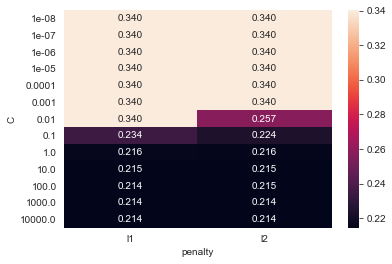

In [15]:
import seaborn as sns; sns.set_style('white')  # plot formatting
# Taking the average of the 5 trials to create 1 heat map based on the averages
heat_results['mean_score_acc'] = heat_results.loc[:,['score_acc_1','score_acc_2','score_acc_3','score_acc_4','score_acc_5','score_acc_6','score_acc_7','score_acc_8','score_acc_9','score_acc_10']].mean(axis=1)

# lets show the results for the saga solver across penalty & C values
sns.heatmap( heat_results.query('solver=="saga"').pivot('C','penalty','mean_score_acc'),
             annot=True, fmt='.3f')
heat_results

,svm_classifier,C,degree,kernel,gamma,score_acc_1,score_acc_2,score_acc_3,score_acc_4,score_acc_5,score_acc_6,score_acc_7,score_acc_8,score_acc_9,score_acc_10,mean_score_acc
0,SVC(),1.000000e-07,2.0,poly,NaN,0.3436,0.3416,0.3450,0.3338,0.3364,0.3420,0.3398,0.3396,0.3430,0.3372,0.34020
1,SVC(),1.000000e-07,3.0,poly,NaN,0.3436,0.3416,0.3450,0.3338,0.3364,0.3420,0.3398,0.3396,0.3430,0.3372,0.34020
2,SVC(),1.000000e-06,2.0,poly,NaN,0.3436,0.3416,0.3450,0.3338,0.3364,0.3420,0.3398,0.3396,0.3430,0.3372,0.34020
3,SVC(),1.000000e-06,3.0,poly,NaN,0.3436,0.3416,0.3450,0.3338,0.3364,0.3420,0.3398,0.3396,0.3430,0.3372,0.34020
4,SVC(),1.000000e-05,2.0,poly,NaN,0.3436,0.3416,0.3450,0.3338,0.3364,0.3420,0.3398,0.3396,0.3430,0.3372,0.34020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,"SVC(C=10.0, gamma=0.1)",1.000000e+03,NaN,rbf,0.05,0.1790,0.1730,0.1702,0.1662,0.1678,0.1718,0.1658,0.1724,0.1656,0.1646,0.16964
117,"SVC(C=10.0, gamma=0.1)",1.000000e+03,NaN,rbf,0.10,0.1668,0.1750,0.1708,0.1616,0.1640,0.1632,0.1664,0.1664,0.1578,0.1640,0.16560
118,"SVC(C=10.0, gamma=0.1)",1.000000e+03,NaN,rbf,0.50,0.2488,0.2520,0.2580,0.2472,0.2570,0.2522,0.2498,0.2472,0.2610,0.2538,0.25270
119,"SVC(C=10.0, gamma=0.1)",1.000000e+03,NaN,rbf,1.00,0.3436,0.3416,0.3450,0.3338,0.3364,0.3420,0.3398,0.3396,0.3430,0.3372,0.34020


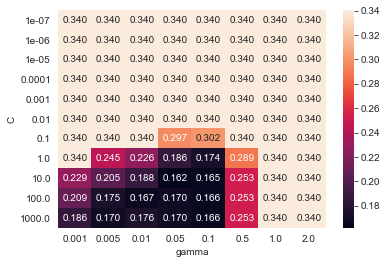

In [16]:
svm_heat_results['mean_score_acc'] = svm_heat_results.loc[:,['score_acc_1','score_acc_2','score_acc_3','score_acc_4','score_acc_5','score_acc_6','score_acc_7','score_acc_8','score_acc_9','score_acc_10']].mean(axis=1)

# lets show the results for the saga solver across penalty & C values
sns.heatmap( svm_heat_results.query('kernel=="rbf"').pivot('C','gamma','mean_score_acc'),
             annot=True, fmt='.3f')
svm_heat_results

,knn_classifier,metric,n_neighbors,weights,score_acc_1,score_acc_2,score_acc_3,score_acc_4,score_acc_5,score_acc_6,score_acc_7,score_acc_8,score_acc_9,score_acc_10,mean_score_acc
0,KNeighborsClassifier(metric='euclidean'),euclidean,1,uniform,0.2942,0.3032,0.3020,0.2938,0.3068,0.3124,0.2878,0.3118,0.2988,0.2900,0.30008
1,KNeighborsClassifier(metric='euclidean'),euclidean,1,distance,0.2942,0.3032,0.3020,0.2938,0.3068,0.3124,0.2878,0.3118,0.2988,0.2900,0.30008
2,KNeighborsClassifier(metric='euclidean'),euclidean,5,uniform,0.2434,0.2646,0.2662,0.2498,0.2632,0.2646,0.2538,0.2740,0.2628,0.2560,0.25984
3,KNeighborsClassifier(metric='euclidean'),euclidean,5,distance,0.2434,0.2646,0.2662,0.2498,0.2632,0.2646,0.2538,0.2740,0.2628,0.2560,0.25984
4,KNeighborsClassifier(metric='euclidean'),euclidean,9,uniform,0.2328,0.2534,0.2494,0.2430,0.2438,0.2544,0.2474,0.2626,0.2506,0.2410,0.24784
5,KNeighborsClassifier(metric='euclidean'),euclidean,9,distance,0.2322,0.2522,0.2490,0.2430,0.2434,0.2538,0.2472,0.2632,0.2498,0.2402,0.24740
6,KNeighborsClassifier(metric='euclidean'),euclidean,13,uniform,0.2330,0.2444,0.2436,0.2416,0.2344,0.2470,0.2434,0.2562,0.2486,0.2342,0.24264
7,KNeighborsClassifier(metric='euclidean'),euclidean,13,distance,0.2324,0.2424,0.2422,0.2404,0.2328,0.2466,0.2430,0.2550,0.2466,0.2334,0.24148
8,KNeighborsClassifier(metric='euclidean'),euclidean,17,uniform,0.2314,0.2426,0.2444,0.2448,0.2362,0.2510,0.2478,0.2510,0.2478,0.2344,0.24314
9,KNeighborsClassifier(metric='euclidean'),euclidean,17,distance,0.2306,0.2388,0.2436,0.2436,0.2342,0.2496,0.2466,0.2502,0.2462,0.2310,0.24144


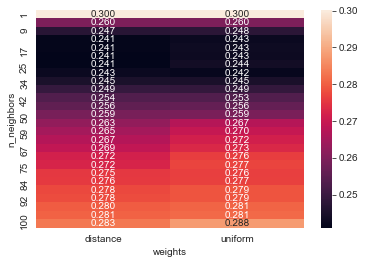

In [17]:
knn_heat_results['mean_score_acc'] = knn_heat_results.loc[:,['score_acc_1','score_acc_2','score_acc_3','score_acc_4','score_acc_5','score_acc_6','score_acc_7','score_acc_8','score_acc_9','score_acc_10']].mean(axis=1)

# lets show the results for the saga solver across penalty & C values
sns.heatmap( knn_heat_results.pivot('n_neighbors','weights','mean_score_acc'),
             annot=True, fmt='.3f')
knn_heat_results

,dt_classifier,ccp_alpha,criterion,max_depth,score_acc_1,score_acc_2,score_acc_3,score_acc_4,score_acc_5,score_acc_6,score_acc_7,score_acc_8,score_acc_9,score_acc_10,mean_score_acc
0,"DecisionTreeClassifier(criterion='entropy', ma...",0.000,gini,1,0.3464,0.3330,0.3444,0.3428,0.3266,0.3368,0.3420,0.3416,0.3510,0.3404,0.34050
1,"DecisionTreeClassifier(criterion='entropy', ma...",0.000,gini,2,0.3286,0.3348,0.3282,0.3316,0.3172,0.3142,0.3228,0.3372,0.3208,0.3242,0.32596
2,"DecisionTreeClassifier(criterion='entropy', ma...",0.000,gini,3,0.3082,0.3230,0.3108,0.3262,0.3050,0.3084,0.3134,0.3302,0.3162,0.3016,0.31430
3,"DecisionTreeClassifier(criterion='entropy', ma...",0.000,gini,4,0.2940,0.3022,0.3012,0.3118,0.2868,0.3010,0.3044,0.3118,0.2970,0.2894,0.29996
4,"DecisionTreeClassifier(criterion='entropy', ma...",0.000,gini,5,0.2742,0.2846,0.2844,0.3070,0.2834,0.2974,0.2922,0.2986,0.2966,0.2868,0.29052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,"DecisionTreeClassifier(criterion='entropy', ma...",0.035,gini,5,0.3464,0.3396,0.3444,0.3428,0.3300,0.3368,0.3420,0.3526,0.3510,0.3404,0.34260
113,"DecisionTreeClassifier(criterion='entropy', ma...",0.035,gini,6,0.3464,0.3396,0.3444,0.3428,0.3300,0.3368,0.3420,0.3526,0.3510,0.3404,0.34260
114,"DecisionTreeClassifier(criterion='entropy', ma...",0.035,gini,7,0.3464,0.3396,0.3444,0.3428,0.3300,0.3368,0.3420,0.3526,0.3510,0.3404,0.34260
115,"DecisionTreeClassifier(criterion='entropy', ma...",0.035,gini,8,0.3464,0.3396,0.3444,0.3428,0.3300,0.3368,0.3420,0.3526,0.3510,0.3404,0.34260


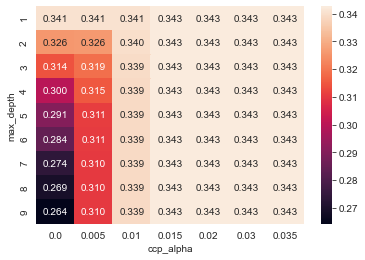

In [18]:
dt_heat_results['mean_score_acc'] = dt_heat_results.loc[:,['score_acc_1','score_acc_2','score_acc_3','score_acc_4','score_acc_5','score_acc_6','score_acc_7','score_acc_8','score_acc_9','score_acc_10']].mean(axis=1)

# lets show the results for the saga solver across penalty & C values
dt_cleaned = dt_heat_results.drop_duplicates(['max_depth','ccp_alpha'])
sns.heatmap( dt_cleaned.pivot('max_depth','ccp_alpha','mean_score_acc'),
             annot=True, fmt='.3f')
dt_cleaned

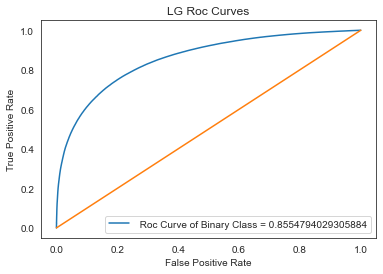

In [19]:
#https://datascience.stackexchange.com/questions/69442/plotting-roc-auc-for-svm-algorithm
from sklearn.metrics import roc_curve, auc
# Concating the list together
lg_Y_test = pd.concat(lg_Y_test_list)
lg_Y_pred = np.concatenate(lg_Y_pred_list)
# Getting the Roc Curve values
test_fpr, test_tpr, test_thresholds = roc_curve(lg_Y_test,lg_Y_pred)
plt.plot(test_fpr, test_tpr, label=" Roc Curve of Binary Class = "+ str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1])
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LG Roc Curves")
plt.show()

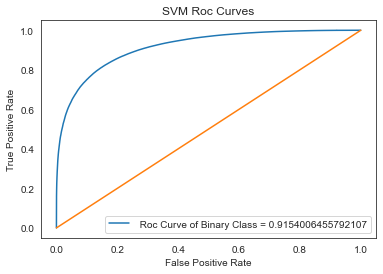

In [20]:
# Concating the list together
svm_Y_test = pd.concat(svm_Y_test_list)
svm_Y_pred = np.concatenate(svm_Y_pred_list)
# Getting the Roc Curve values
test_fpr, test_tpr, test_thresholds = roc_curve(svm_Y_test,svm_Y_pred)
plt.plot(test_fpr, test_tpr, label=" Roc Curve of Binary Class = "+ str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1])
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM Roc Curves")
plt.show()

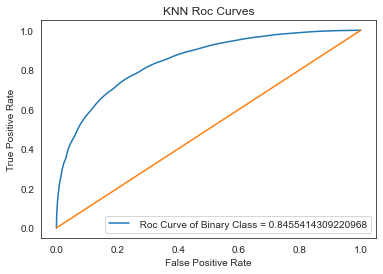

In [21]:
# Concating the list together
knn_Y_test = pd.concat(knn_Y_test_list)
knn_Y_pred = np.concatenate(knn_Y_pred_list)
# Getting the Roc Curve values
test_fpr, test_tpr, test_thresholds = roc_curve(knn_Y_test,knn_Y_pred)
plt.plot(test_fpr, test_tpr, label=" Roc Curve of Binary Class = "+ str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1])
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("KNN Roc Curves")
plt.show()

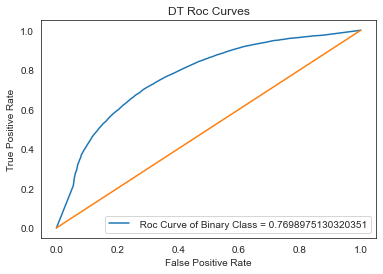

In [22]:
# Concating the list together
dt_Y_test = pd.concat(dt_Y_test_list)
dt_Y_pred = np.concatenate(dt_Y_pred_list)
# Getting the Roc Curve values
test_fpr, test_tpr, test_thresholds = roc_curve(dt_Y_test,dt_Y_pred)
plt.plot(test_fpr, test_tpr, label=" Roc Curve of Binary Class = "+ str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1])
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("DT Roc Curves")
plt.show()